In [4]:
from scipy import signal
from scipy.linalg import eig
import control as ct
import numpy as np
import matplotlib.pyplot as plt

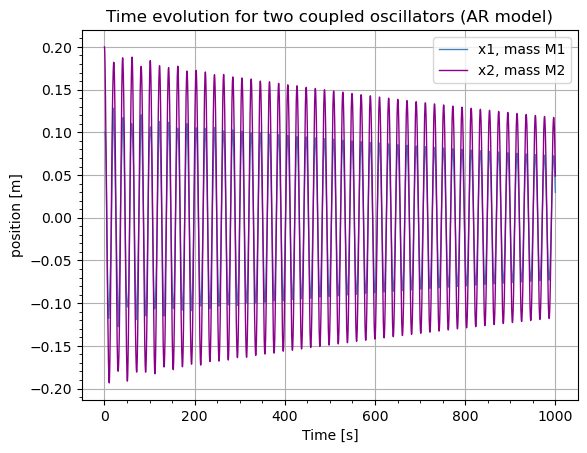

In [16]:
#--------------------------AR model------------------------#
def AR_model(y, A, B, u):
    return A @ y + B * u  #nd array of y at instant n+1

#--------------------------Right Hand Side------------------------#
def matrix(gamma, M1, M2, K1, K2, dt):

    #defne the rows of the matrix A
    A_row1 = [1-(dt*gamma/M1), dt*gamma/M1, -dt*(K1+K2)/M1, dt*K2/M1]
    A_row2 = [dt*gamma/M2, 1-(dt*gamma/M2), dt*K2/M2, -dt*K2/M2]
    A_row3 = [dt, 0, 1, 0]
    A_row4 = [0, dt, 0, 1]

    #define A and B
    A = np.array([A_row1, A_row2, A_row3, A_row4])
    B = np.array((dt/M1,0, 0, 0))
    return A, B

#----------------------------Sine function------------------------#
def sin_function(t, F0, w):
    return F0 * np.sin(w*t)

#--------------------------Temporal evolution----------------------#
def evolution(evol_method, Nt_step, dt, physical_params, signal_params, F, file_name = None):
    #-----------------Initialize the problem-------------------#
    tmax = dt * Nt_step                #total time of simulation
    tt = np.arange(0, tmax, dt)        #temporal grid
    y0 = np.array((0, 0, 0.1, 0.2))        #initial condition
    y_t = np.copy(y0)                  #create a copy to evolve it in time
    F_signal = F(tt, *signal_params)   #external force applied to the system in time
    #----------------------------------------------------------#

    #----------------------Time evolution----------------------#
    v1 = []      #initialize list of v1 value
    v2 = []      # initialize list of v2 value
    x1 = []      #initialize list of x1 value
    x2 = []      # initialize list of x2 value

    #compute the matrices of the system
    A, B = matrix(*physical_params)

    #temporal evolution when the ext force is applied
    for Fi in F_signal:
        y_t = evol_method(y_t, A, B, Fi)   #step n+1
        v1.append(y_t[0])
        v2.append(y_t[1])
        x1.append(y_t[2])
        x2.append(y_t[3])

    return tt, np.array(v1), np.array(v2), np.array(x1), np.array(x2)


if __name__ == '__main__':
    # create an array of frequencies
    f = np.linspace(1e-2,1e1,10000)
    w = 2*np.pi*f

    #Parameters of the simulation
    Nt_step = 1e6     #temporal steps
    dt = 1e-3         #temporal step size

    #Parameters of the system
    gamma = 0.2     #viscous friction coeff [kg/m*s]
    M1 = 20        #filter mass [Kg]
    M2 = 20
    K1 = 5        #spring constant [N/m]
    K2 = 5
    t0 = 0          #parameter of the step function [s]
    F0 = 0          #amplitude of the external force
    wn = 10          #f of the ext force

    #Signal applied to the system
    F = sin_function

    #Simulation
    physical_params = [gamma, M1, M2, K1, K2, dt]
    signal_params = [F0, wn]
    simulation_params = [AR_model, Nt_step, dt]
    tt, v1, v2, x1, x2 = evolution(*simulation_params, physical_params, signal_params, F, file_name =None)

    # --------------------------Plot results----------------------#
    #fig = plt.figure(figsize=(12,10))
    plt.title('Time evolution for two coupled oscillators (AR model)')
    plt.xlabel('Time [s]')
    plt.ylabel('position [m]')
    plt.grid(True)
    plt.minorticks_on()

    plt.plot(tt, x1, linestyle='-', linewidth=1, marker='', color='steelblue', label='x1, mass M1')
    plt.plot(tt, x2, linestyle='-', linewidth=1, marker='', color='darkmagenta', label='x2, mass M2')
    plt.legend()

    #plt.savefig('2MtimeEvol')
    #plt.show()

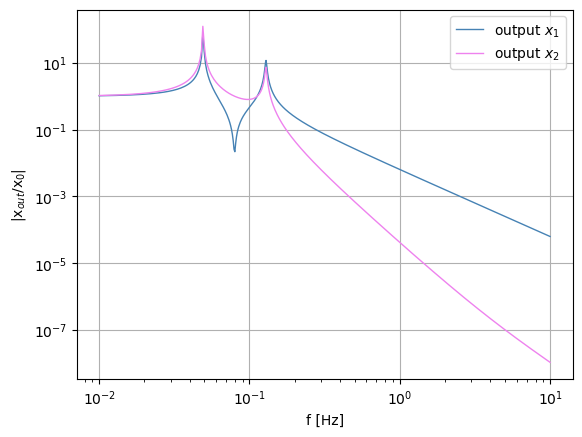

In [17]:
#-----------------------Transfer Function----------------------#
def TransferFunc (w, M1, M2, K1, K2, gamma):
    #define the matrices of the system from the state-space equations
     #defne the rows of the matrix A
    Id = np.eye(2)
    A_row1 = [-gamma/M1, gamma/M1, -(K1+K2)/M1, K2/M1]
    A_row2 = [gamma/M2, -gamma/M2, K2/M2, -K2/M2]
    A_row3 = [1, 0, 0, 0]
    A_row4 = [0, 1, 0, 0]

    #define A and B
    A = np.array([A_row1, A_row2, A_row3, A_row4])
    B = np.array((K1/M1,0, 0, 0))
    C = np.block([0*Id, Id])

    #initialize the transfer matrix
    H = np.zeros((2, len(w)),dtype = 'complex_') #the matrix has 5 rows (like the number of output)
                                                       #and len(w) columns (all the range of frequencies).
                                                       #In each row there is the Tf of a single output
    for i in range(len(w)):
        H_lenOUT = C @ np.linalg.inv((1j*w[i])*np.eye(4) - A) @ B #array, len=number of output, these elements are
                                                                    #the values of the Tf of each output at a given freq
        #store each value of the Tf in the corresponding row of H
        H[0][i] = H_lenOUT[0]
        H[1][i] = H_lenOUT[1]
    return H



gamma = 0.2     #viscous friction coeff [kg/m*s]
M1 = 20        #filter mass [Kg]
M2 = 20
K1 = 5        #spring constant [N/m]
K2 = 5

# compute the transfer function
Tf = TransferFunc(w, M1, M2, K1, K2, gamma)
# compute the magnitude of the transfer function
H = (np.real(Tf)**2+np.imag(Tf)**2)**(1/2)

#fig = plt.figure(figsize=(10, 7))
plt.xlabel('f [Hz]')
plt.ylabel('|x$_{out}$/x$_0$|')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.minorticks_on()

plt.plot(f, H[0], linestyle='-', linewidth=1, marker='', color='steelblue', label='output $x_1$')
plt.plot(f, H[1], linestyle='-', linewidth=1, marker='', color='violet', label='output $x_2$')
plt.legend()

#plt.savefig('2M_TF')
plt.show()


Poli del sistema:  [-0.00947217+0.80894707j -0.00947217-0.80894707j -0.00052783+0.30902207j
 -0.00052783-0.30902207j]
Real part is: sigma =  [-0.00947217 -0.00947217 -0.00052783 -0.00052783]
Imaginary part is: w =  [ 0.80894707 -0.80894707  0.30902207 -0.30902207]
Normal frequencies are: 0.128748, 0.049182


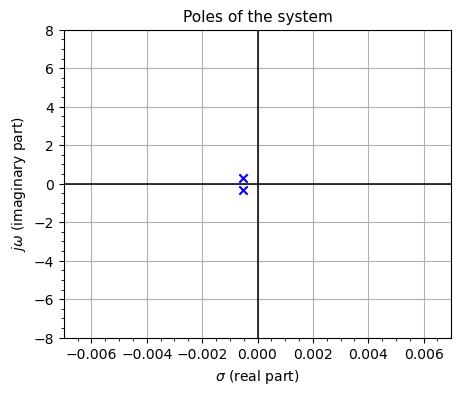

In [25]:
Id = np.eye(2)
A_row1 = [-gamma/M1, gamma/M1, -(K1+K2)/M1, K2/M1]
A_row2 = [gamma/M2, -gamma/M2, K2/M2, -K2/M2]
A_row3 = [1, 0, 0, 0]
A_row4 = [0, 1, 0, 0]

#define A and B
A = np.array([A_row1, A_row2, A_row3, A_row4])
B = np.array([[K1/M1], [0], [0], [0]])
C = np.block([0*Id, Id])
D = np.array([[0], [0]])

# Find poles of the system
poles, _ = eig(A)

#extract imaginary and real part of poles
real_parts = np.real(poles)
imag_parts = np.imag(poles)

print("Poli del sistema: ", poles)
print('Real part is: sigma = ', real_parts)
print('Imaginary part is: w = ', imag_parts)
print('Normal frequencies are: %f, %f' % (imag_parts[0]/(2*np.pi),(imag_parts[2]/(2*np.pi))))

# --------------------------Plot results----------------------#
#plot poles
plt.figure(figsize=(5, 4))
plt.title('Poles of the system',size=11)
plt.xlabel('$\sigma$ (real part)')
plt.ylabel('$j \omega$ (imaginary part)')
plt.xlim(-0.007, 0.007)
plt.ylim(-8, 8)
plt.grid(True)
plt.minorticks_on()

plt.axhline(y=0, linestyle='-', color='black', linewidth=1.1)
plt.axvline(x=0, linestyle='-', color='black', linewidth=1.1)
plt.scatter(real_parts, imag_parts, marker='x', color='blue')

#plt.savefig('2Mpoles')

In [13]:
# Crea il sistema
sys = ct.StateSpace(A, B, C, D)

# Definisci i poli desiderati
desired_poles = np.array([-0.0947217+0.80894707j, -0.0947217-0.80894707j, -0.052783+0.30902207j,
 -0.052783-0.30902207j]) 

# Calcola il vettore di guadagno K utilizzando la funzione place
K = ct.place(A, B, desired_poles)

print(K)

[[ 1.1000376   0.27659982  0.11282174 -0.06968225]]


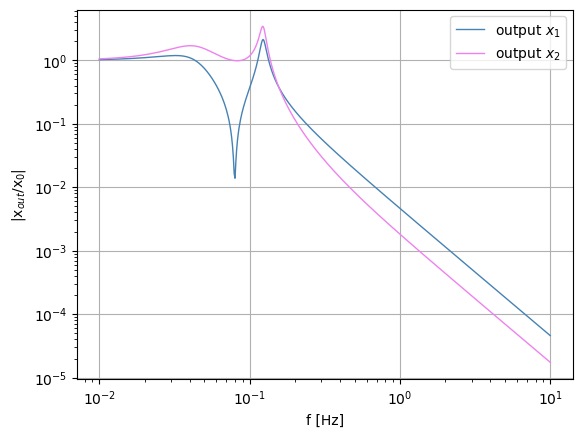

In [19]:
#-----------------------Transfer Function----------------------#
def TransferFunc (w, M1, M2, K1, K2, gamma):
    #define the matrices of the system from the state-space equations
     #defne the rows of the matrix A
    Id = np.eye(2)
    A_row1 = [-gamma/M1, gamma/M1, -(K1+K2)/M1, K2/M1]
    A_row2 = [gamma/M2, -gamma/M2, K2/M2, -K2/M2]
    A_row3 = [1, 0, 0, 0]
    A_row4 = [0, 1, 0, 0]

    #define A and B
    A = np.array([A_row1, A_row2, A_row3, A_row4])
    B = np.array((K1/M1,0, 0, 0))
    C = np.block([0*Id, Id])

    #initialize the transfer matrix
    H = np.zeros((2, len(w)),dtype = 'complex_') #the matrix has 5 rows (like the number of output)
                                                       #and len(w) columns (all the range of frequencies).
                                                       #In each row there is the Tf of a single output
    for i in range(len(w)):
        H_lenOUT = C @ np.linalg.inv((1j*w[i])*np.eye(4) - (A-B*K)) @ B #array, len=number of output, these elements are
                                                                    #the values of the Tf of each output at a given freq
        #store each value of the Tf in the corresponding row of H
        H[0][i] = H_lenOUT[0]
        H[1][i] = H_lenOUT[1]
    return H



gamma = 0.2     #viscous friction coeff [kg/m*s]
M1 = 20        #filter mass [Kg]
M2 = 20
K1 = 5        #spring constant [N/m]
K2 = 5

# compute the transfer function
Tf = TransferFunc(w, M1, M2, K1, K2, gamma)
# compute the magnitude of the transfer function
H = (np.real(Tf)**2+np.imag(Tf)**2)**(1/2)

#fig = plt.figure(figsize=(10, 7))
plt.xlabel('f [Hz]')
plt.ylabel('|x$_{out}$/x$_0$|')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.minorticks_on()

plt.plot(f, H[0], linestyle='-', linewidth=1, marker='', color='steelblue', label='output $x_1$')
plt.plot(f, H[1], linestyle='-', linewidth=1, marker='', color='violet', label='output $x_2$')
plt.legend()

#plt.savefig('2M_FSF_Tf')
plt.show()


Poli del sistema:  [-0.0947217+0.80894707j -0.0947217-0.80894707j -0.052783 +0.30902207j
 -0.052783 -0.30902207j]
Real part is: sigma =  [-0.0947217 -0.0947217 -0.052783  -0.052783 ]
Imaginary part is: w =  [ 0.80894707 -0.80894707  0.30902207 -0.30902207]
Normal frequencies are: 0.128748, 0.049182


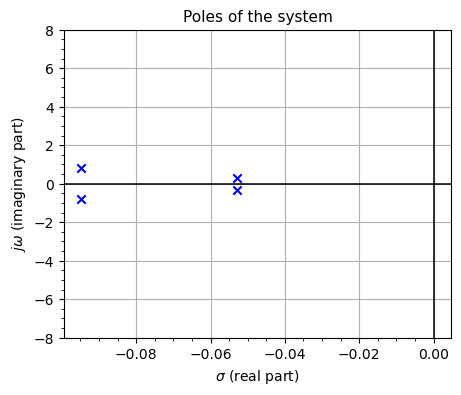

In [23]:
Id = np.eye(2)
A_row1 = [-gamma/M1, gamma/M1, -(K1+K2)/M1, K2/M1]
A_row2 = [gamma/M2, -gamma/M2, K2/M2, -K2/M2]
A_row3 = [1, 0, 0, 0]
A_row4 = [0, 1, 0, 0]

#define A and B
A = np.array([A_row1, A_row2, A_row3, A_row4])
B = np.array([[K1/M1], [0], [0], [0]])
C = np.block([0*Id, Id])
D = np.array([[0], [0]])

# Find poles of the system
poles, _ = eig((A-B*K))

#extract imaginary and real part of poles
real_parts = np.real(poles)
imag_parts = np.imag(poles)

print("Poli del sistema: ", poles)
print('Real part is: sigma = ', real_parts)
print('Imaginary part is: w = ', imag_parts)
print('Normal frequencies are: %f, %f' % (imag_parts[0]/(2*np.pi),(imag_parts[2]/(2*np.pi))))

# --------------------------Plot results----------------------#
#plot poles
plt.figure(figsize=(5, 4))
plt.title('Poles of the system',size=11)
plt.xlabel('$\sigma$ (real part)')
plt.ylabel('$j \omega$ (imaginary part)')
plt.ylim(-8, 8)
plt.grid(True)
plt.minorticks_on()

plt.axhline(y=0, linestyle='-', color='black', linewidth=1.1)
plt.axvline(x=0, linestyle='-', color='black', linewidth=1.1)
plt.scatter(real_parts, imag_parts, marker='x', color='blue')

#plt.savefig('2M_FSF_poles')

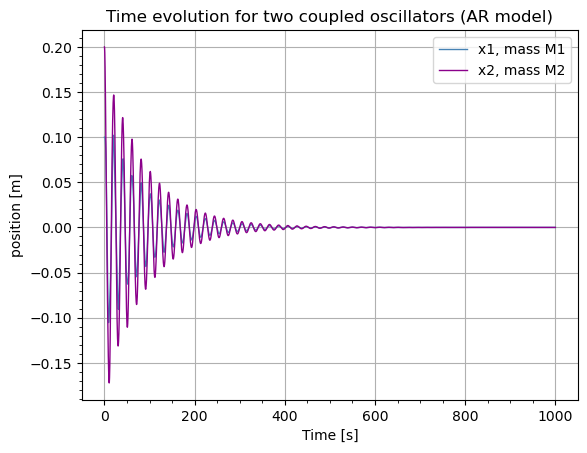

In [21]:
#--------------------------AR model------------------------#
def FSF_AR_model(y, A, B, K, N, r):
    return (A - np.outer(B, K)) @ y + B * N * r   #nd array of y at instant n+1

#--------------------------Right Hand Side------------------------#
def matrix(gamma, M1, M2, K1, K2, dt):

    #defne the rows of the matrix A
    A_row1 = [1-(dt*gamma/M1), dt*gamma/M1, -dt*(K1+K2)/M1, dt*K2/M1]
    A_row2 = [dt*gamma/M2, 1-(dt*gamma/M2), dt*K2/M2, -dt*K2/M2]
    A_row3 = [dt, 0, 1, 0]
    A_row4 = [0, dt, 0, 1]

    #define A and B
    A = np.array([A_row1, A_row2, A_row3, A_row4])
    B = np.array((dt/M1,0, 0, 0))
    return A, B

#--------------------------Temporal evolution----------------------#
def evolution(evol_method, Nt_step, dt, physical_params, K, control_params):
    #-----------------Initialize the problem-------------------#
    tmax = dt * Nt_step                #total time of simulation
    tt = np.arange(0, tmax, dt)        #temporal grid
    y0 = np.array((0, 0, 0.1, 0.2))        #initial condition
    y_t = np.copy(y0)                  #create a copy to evolve it in time
    #----------------------------------------------------------#

    #----------------------Time evolution----------------------#
    v1 = []      #initialize list of v1 value
    v2 = []      # initialize list of v2 value
    x1 = []      #initialize list of x1 value
    x2 = []      # initialize list of x2 value

    #compute the matrices of the system
    A, B = matrix(*physical_params)

    #temporal evolution when the ext force is applied
    for t in tt:
        y_t = evol_method(y_t, A, B, K, *control_params)   #step n+1
        v1.append(y_t[0])
        v2.append(y_t[1])
        x1.append(y_t[2])
        x2.append(y_t[3])

    return tt, np.array(v1), np.array(v2), np.array(x1), np.array(x2)


if __name__ == '__main__':
    # create an array of frequencies
    f = np.linspace(1e-2,1e1,10000)
    w = 2*np.pi*f

    #Parameters of the simulation
    Nt_step = 1e6     #temporal steps
    dt = 1e-3         #temporal step size

    #Parameters of the system
    gamma = 0.2     #viscous friction coeff [kg/m*s]
    M1 = 20        #filter mass [Kg]
    M2 = 20
    K1 = 5        #spring constant [N/m]
    K2 = 5
  
    # control parameters
    r = 0  # theta ref
    N = 112  # factor for scaling the input

    #Simulation
    physical_params = [gamma, M1, M2, K1, K2, dt]
    simulation_params = [FSF_AR_model, Nt_step, dt]
    control_params = [N, r]
    tt, v1, v2, x1, x2 = evolution(*simulation_params, physical_params, K, control_params)

    # --------------------------Plot results----------------------#
    #fig = plt.figure(figsize=(12,10))
    plt.title('Time evolution for two coupled oscillators (AR model)')
    plt.xlabel('Time [s]')
    plt.ylabel('position [m]')
    plt.grid(True)
    plt.minorticks_on()

    plt.plot(tt, x1, linestyle='-', linewidth=1, marker='', color='steelblue', label='x1, mass M1')
    plt.plot(tt, x2, linestyle='-', linewidth=1, marker='', color='darkmagenta', label='x2, mass M2')
    plt.legend()

    #plt.savefig('2M_FSF_timeEvol')
